In [6]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video
import cfgrib
import math

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

In [7]:
f_vt_vn = 'data/lfff00010000'
f_grid  = 'data/grids/icon_grid_0001_R19B08_mch.nc'

dss = cfgrib.open_datasets(f_vt_vn, engine='cfgrib',
                        backend_kwargs={
                            'indexpath': '', 'errors': 'ignore',
                            "read_keys": ["typeOfLevel", "gridType"],
                            "filter_by_keys": {"typeOfLevel": "generalVerticalLayer"},
                        }, encode_cf=("time", "geography", "vertical"))
ds_cell = dss[0]
ds_edge = dss[1]

In [3]:
ds_cell["T"]

<xarray.DataArray 'T' (generalVerticalLayer: 80, values: 1043968)>
[83517440 values with dtype=float32]
Coordinates:
    number                int64 1
    time                  datetime64[ns] 2022-02-16
    step                  timedelta64[ns] 01:00:00
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
    valid_time            datetime64[ns] 2022-02-16T01:00:00
Dimensions without coordinates: values
Attributes:
    GRIB_paramId:                    500014
    GRIB_dataType:                   cp
    GRIB_numberOfPoints:             1043968
    GRIB_typeOfLevel:                generalVerticalLayer
    GRIB_stepUnits:                  0
    GRIB_stepType:                   instant
    GRIB_gridType:                   unstructured_grid
    GRIB_NV:                         6
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t
    GRIB_gridDefinitionDescription:  General unstructured grid
    GRIB_missingValue:               9999
    GRIB_name:                       Temperature
    GRIB_shortName:                  T
    GRIB_totalNumber:                11
    GRIB_units:                      K
    long_name:                       original GRIB paramId: 500014
    units:                           1

In [8]:

ds_grid = psy.open_dataset(f_grid)
ds_grid

<xarray.Dataset>
Dimensions:                        (cell: 1043968, vertex: 523485,
                                    edge: 1567452, nv: 3, nc: 2, ne: 6, no: 4,
                                    max_chdom: 1, cell_grf: 14, edge_grf: 24,
                                    vert_grf: 13)
Coordinates:
    clon                           (cell) float64 ...
    clat                           (cell) float64 ...
    vlon                           (vertex) float64 ...
    vlat                           (vertex) float64 ...
    elon                           (edge) float64 ...
    elat                           (edge) float64 ...
    clon_vertices                  (cell, nv) float64 ...
    clat_vertices                  (cell, nv) float64 ...
    elon_vertices                  (edge, no) float64 ...
    elat_vertices                  (edge, no) float64 ...
    vlon_vertices                  (vertex, ne) float64 ...
    vlat_vertices                  (vertex, ne) float64 ...
Dimensions without coordinates: cell, vertex, edge, nv, nc, ne, no, max_chdom,
                                cell_grf, edge_grf, vert_grf
Data variables: (12/45)
    cartesian_x_vertices           (vertex) float64 ...
    cartesian_y_vertices           (vertex) float64 ...
    cartesian_z_vertices           (vertex) float64 ...
    cell_area                      (cell) float64 ...
    dual_area                      (vertex) float64 ...
    lon_cell_centre                (cell) float64 ...
    ...                             ...
    end_idx_e                      (max_chdom, edge_grf) int32 ...
    refin_v_ctrl                   (vertex) int32 ...
    start_idx_v                    (max_chdom, vert_grf) int32 ...
    end_idx_v                      (max_chdom, vert_grf) int32 ...
    parent_edge_index              (edge) int32 ...
    parent_vertex_index            (vertex) int32 ...
Attributes: (12/18)
    title:                ICON grid description
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    source:               svn://rclh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    number_of_grid_used:  1
    ICON_grid_file_uri:   
    centre:               215
    ...                   ...
    inverse_flattening:   0.0
    grid_level:           8
    grid_root:            19
    uuidOfParHGrid:       e6ddd597-9c90-27b1-fbac-c40d47f72ba0
    uuidOfHGrid:          5a0a863d-2523-9515-7789-4930e3452bc0
    global_grid:          0

In [10]:
def combine_grib_grid(file, location, grid):
    
    result = None
    if location == 'edge':
        result = file.rename({'time': 'init_time','valid_time': 'time'}
                            ).rename_dims({'values':location}
                            ).assign_coords(
                            elon=('edge', np.float32(grid.coords['elon'].values))
                            ).assign_coords(
                            elat=('edge', np.float32(grid.coords['elat'].values))
                            ).assign_coords(
                            elat_bnds=(('edge','no'), np.float32(grid.coords['elat_vertices'].values))
                            ).assign_coords(
                            elon_bnds=(('edge','no'), np.float32(grid.coords['elon_vertices'].values))
                            ).expand_dims('time')
        result.elon.attrs['standard_name']='longitude'
        result.elon.attrs['long_name']='edge longitude'
        result.elon.attrs['units']='radian'
        result.elon.attrs['bounds']='elon_bnds'
        result.elat.attrs['standard_name']='latitude'
        result.elat.attrs['long_name']='edge latitude'
        result.elat.attrs['units']='radian'
        result.elat.attrs['bounds']='elat_bnds'

    elif location == 'cell':
        result = file.rename({'time': 'init_time','valid_time': 'time'}
                            ).rename_dims({'values':location}
                            ).assign_coords(
                            clon=('cell', np.float32(grid.coords['clon'].values))
                            ).assign_coords(
                            clat=('cell', np.float32(grid.coords['clat'].values))
                            ).assign_coords(
                            clat_bnds=(('cell','vertices'), np.float32(grid.coords['clat_vertices'].values))
                            ).assign_coords(
                            clon_bnds=(('cell','vertices'), np.float32(grid.coords['clon_vertices'].values))
                            ).expand_dims('time')
        
        result.clon.attrs['standard_name']='longitude'
        result.clon.attrs['long_name']='cell longitude'
        result.clon.attrs['units']='radian'
        result.clon.attrs['bounds']='clon_bnds'
        result.clat.attrs['standard_name']='latitude'
        result.clat.attrs['long_name']='cell latitude'
        result.clat.attrs['units']='radian'
        result.clat.attrs['bounds']='clat_bnds'

    result.time.attrs['axis']='T'
    #result.generalVerticalLayer.attrs['positive']='up'
    #result.generalVerticalLayer.attrs['axis']='Z'
    
    if location == 'edge':
        result=result.assign(zonal_normal_primal_edge=grid["zonal_normal_primal_edge"])
        result=result.assign(meridional_normal_primal_edge=grid["meridional_normal_primal_edge"])
        result=result.assign(edge_system_orientation=grid["edge_system_orientation"])

        clat_ind_access = lambda x: ds_grid.coords["clat"][x-1]
        clon_ind_access = lambda x: ds_grid.coords["clon"][x-1]
        
        result.coords["elat_bnds"][:,2] = result.coords["elat_bnds"][:,1]
        result.coords["elat_bnds"][:,1] = xr.apply_ufunc(clat_ind_access, ds_grid["adjacent_cell_of_edge"][1,:])
        result.coords["elat_bnds"][:,3] = xr.apply_ufunc(clat_ind_access, ds_grid["adjacent_cell_of_edge"][0,:])
        result.coords["elon_bnds"][:,2] = result.coords["elon_bnds"][:,1]
        result.coords["elon_bnds"][:,1] = xr.apply_ufunc(clon_ind_access, ds_grid["adjacent_cell_of_edge"][1,:])
        result.coords["elon_bnds"][:,3] = xr.apply_ufunc(clon_ind_access, ds_grid["adjacent_cell_of_edge"][0,:])
        
    return result

ds_cell_combi = combine_grib_grid(ds_cell, 'cell', ds_grid)
ds_edge_combi = combine_grib_grid(ds_edge, 'edge', ds_grid)
ds_edge_combi

<xarray.Dataset>
Dimensions:                        (generalVerticalLayer: 80, time: 1,
                                    edge: 1567452, no: 4)
Coordinates:
    number                         int64 1
    init_time                      datetime64[ns] 2022-02-16
    step                           timedelta64[ns] 01:00:00
  * generalVerticalLayer           (generalVerticalLayer) float64 1.0 ... 80.0
  * time                           (time) datetime64[ns] 2022-02-16T01:00:00
    elon                           (edge) float32 0.2893 0.2896 ... 0.2421
    elat                           (edge) float32 0.7384 0.7386 ... 0.7472
    elat_bnds                      (edge, no) float32 0.7383 0.7472 ... 0.7472
    elon_bnds                      (edge, no) float32 0.2892 0.2422 ... 0.242
Dimensions without coordinates: edge, no
Data variables:
    VN                             (time, generalVerticalLayer, edge) float32 ...
    VT                             (time, generalVerticalLayer, edge) float32 ...
    zonal_normal_primal_edge       (edge) float64 ...
    meridional_normal_primal_edge  (edge) float64 ...
    edge_system_orientation        (edge) int32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich

In [12]:
fds_edge = ds_edge_combi.where((ds_edge_combi.coords["elon"] > 0.165) & (ds_edge_combi.coords["elon"] < 0.18) 
                     & (ds_edge_combi.coords["elat"] > 0.8) & (ds_edge_combi.coords["elat"] < 0.81),
                                                                drop=True)


fds_cell = ds_cell_combi.where((ds_cell_combi.coords["clon"] > 0.165) & (ds_cell_combi.coords["clon"] < 0.18) 
                     & (ds_cell_combi.coords["clat"] > 0.8) & (ds_cell_combi.coords["clat"] < 0.81),
                                                                drop=True)
fds_cell

<xarray.Dataset>
Dimensions:               (time: 1, generalVerticalLayer: 80, cell: 3821,
                           vertices: 3)
Coordinates:
    number                int64 1
    init_time             datetime64[ns] 2022-02-16
    step                  timedelta64[ns] 01:00:00
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
  * time                  (time) datetime64[ns] 2022-02-16T01:00:00
    clon                  (cell) float32 0.1651 0.1651 0.1799 ... 0.1658 0.166
    clat                  (cell) float32 0.8002 0.8 0.8095 ... 0.8084 0.8084
    clat_bnds             (cell, vertices) float32 0.8003 0.8001 ... 0.8083
    clon_bnds             (cell, vertices) float32 0.1651 0.1649 ... 0.1662
Dimensions without coordinates: cell, vertices
Data variables:
    P                     (time, generalVerticalLayer, cell) float32 4.66e+03...
    T                     (time, generalVerticalLayer, cell) float32 212.7 .....
    U                     (time, generalVerticalLayer, cell) float32 12.97 .....
    V                     (time, generalVerticalLayer, cell) float32 -6.319 ....
    QV                    (time, generalVerticalLayer, cell) float32 3.083e-0...
    QC                    (time, generalVerticalLayer, cell) float32 0.0 ... 0.0
    QI                    (time, generalVerticalLayer, cell) float32 0.0 ... 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich

In [13]:
fds_cell.T.encoding['coordinates'] = 'clon clat'
fds_cell.T

<xarray.DataArray 'T' (time: 1, generalVerticalLayer: 80, cell: 3821)>
array([[[212.70956, 212.70212, 213.332  , ..., 213.46188, 213.46457,
         213.47092],
        [215.50221, 215.49452, 215.1946 , ..., 214.07936, 214.09023,
         214.11977],
        [215.68611, 215.70454, 215.2679 , ..., 215.70552, 215.69954,
         215.65572],
        ...,
        [276.30328, 278.07184, 264.34137, ..., 275.0103 , 275.9566 ,
         274.3824 ],
        [276.60965, 278.39774, 264.5071 , ..., 275.32254, 276.28445,
         274.59988],
        [275.72632, 276.2849 , 264.13745, ..., 274.0193 , 275.30444,
         273.2566 ]]], dtype=float32)
Coordinates:
    number                int64 1
    init_time             datetime64[ns] 2022-02-16
    step                  timedelta64[ns] 01:00:00
  * generalVerticalLayer  (generalVerticalLayer) float64 1.0 2.0 ... 79.0 80.0
  * time                  (time) datetime64[ns] 2022-02-16T01:00:00
    clon                  (cell) float32 0.1651 0.1651 0.1799 ... 0.1658 0.166
    clat                  (cell) float32 0.8002 0.8 0.8095 ... 0.8084 0.8084
Dimensions without coordinates: cell
Attributes:
    GRIB_paramId:                    500014
    GRIB_dataType:                   cp
    GRIB_numberOfPoints:             1043968
    GRIB_typeOfLevel:                generalVerticalLayer
    GRIB_stepUnits:                  0
    GRIB_stepType:                   instant
    GRIB_gridType:                   unstructured_grid
    GRIB_NV:                         6
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t
    GRIB_gridDefinitionDescription:  General unstructured grid
    GRIB_missingValue:               9999
    GRIB_name:                       Temperature
    GRIB_shortName:                  T
    GRIB_totalNumber:                11
    GRIB_units:                      K
    long_name:                       original GRIB paramId: 500014
    units:                           1

psyplot.project.Project([    arr0: 1-dim DataArray of T, with (cell)=(3821,), number=1, init_time=2022-02-16, step=0 days 01:00:00, generalVerticalLayer=1.0, time=2022-02-16T01:00:00])

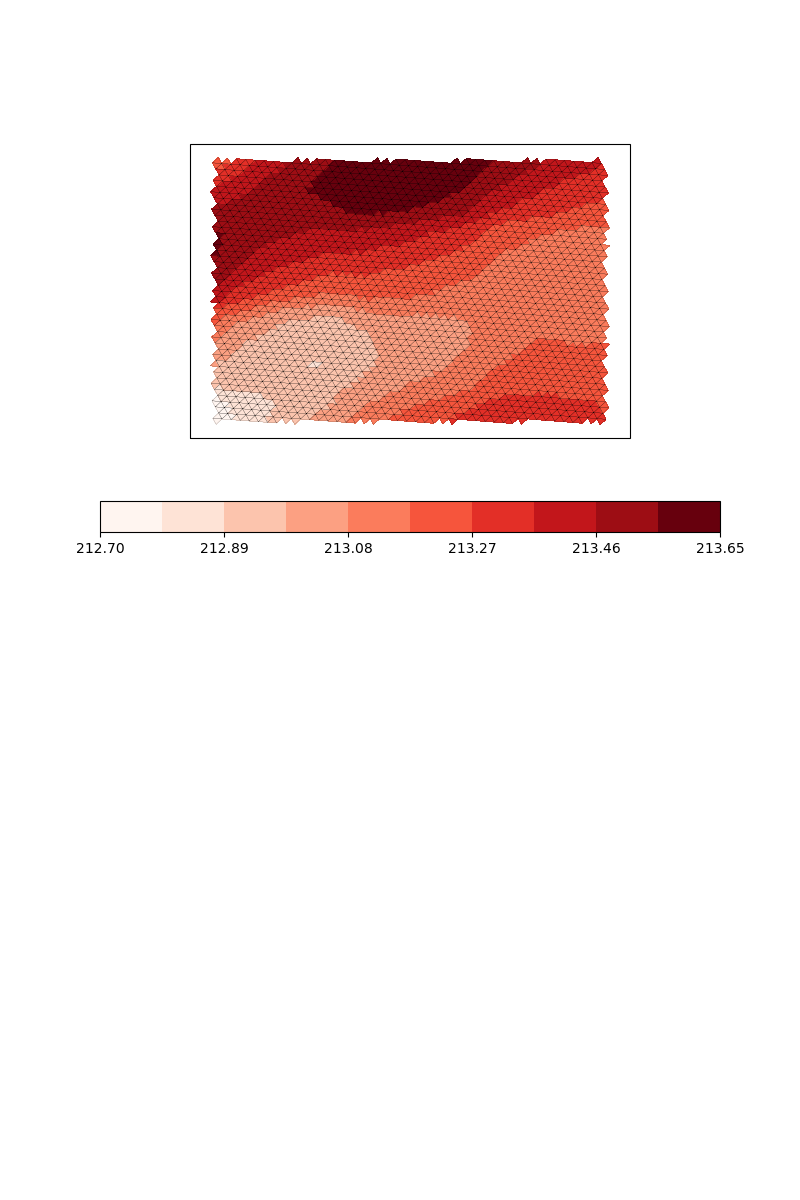

In [14]:
fds_cell.psy.plot.mapplot(
     name='T', 
     xgrid=None, ygrid=None, 
     datagrid=dict(c='k', lw=0.1),
     ax=(2, 1),
     cmap='Reds', 
     #map_extent=[6.7, 7.0, 46.6, 46.75]
     )


In [15]:
nx=8+1
ny=4+1
max_lon=np.max(ds_grid.coords["clon"])
min_lon=np.min(ds_grid.coords["clon"])
max_lat=np.max(ds_grid.coords["clat"])
min_lat=np.min(ds_grid.coords["clat"])
dlon=(max_lon-min_lon)/(nx-1)
dlat=(max_lat-min_lat)/(ny-1)
cg_data = np.random.random((ny, nx))
max_lon,max_lat, min_lon, min_lat

(<xarray.DataArray 'clon' ()>
 array(0.30736461),
 <xarray.DataArray 'clat' ()>
 array(0.88033287),
 <xarray.DataArray 'clon' ()>
 array(-0.0128734),
 <xarray.DataArray 'clat' ()>
 array(0.73468767))

In [10]:
var=fds_cell["T"][dict(generalVerticalLayer=0,time=0)]
len(var)

3821

In [11]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


In [31]:
ix1 = np.clip( ((ds_grid.coords["clon"] - min_lon)/dlon).astype(int),0,nx-2)
iy1 = np.clip( ((ds_grid.coords["clat"] - min_lat)/dlat).astype(int),0,ny-2)
ix2=ix1+1
iy2=iy1+1
x1=min_lon+ix1*dlon
x2=min_lon+ix2*dlon
y1=min_lat+iy1*dlat
y2=min_lat+iy2*dlat
x=ds_grid.coords["clon"]
y=ds_grid.coords["clat"]

fq11=cg_data[iy1,ix1]
print(np.max(ix2))
fq21=cg_data[iy1,ix2]
fq12=cg_data[iy2,ix1]
fq22=cg_data[iy2,ix2]

# var=cg_data[iy1,ix1]
# ds_cell_combi["rand_cg"] = xr.Variable(('cell'), var)
# ds_cell_combi.rand_cg.encoding['coordinates'] = 'clon clat'


<xarray.DataArray 'clon' ()>
array(8)


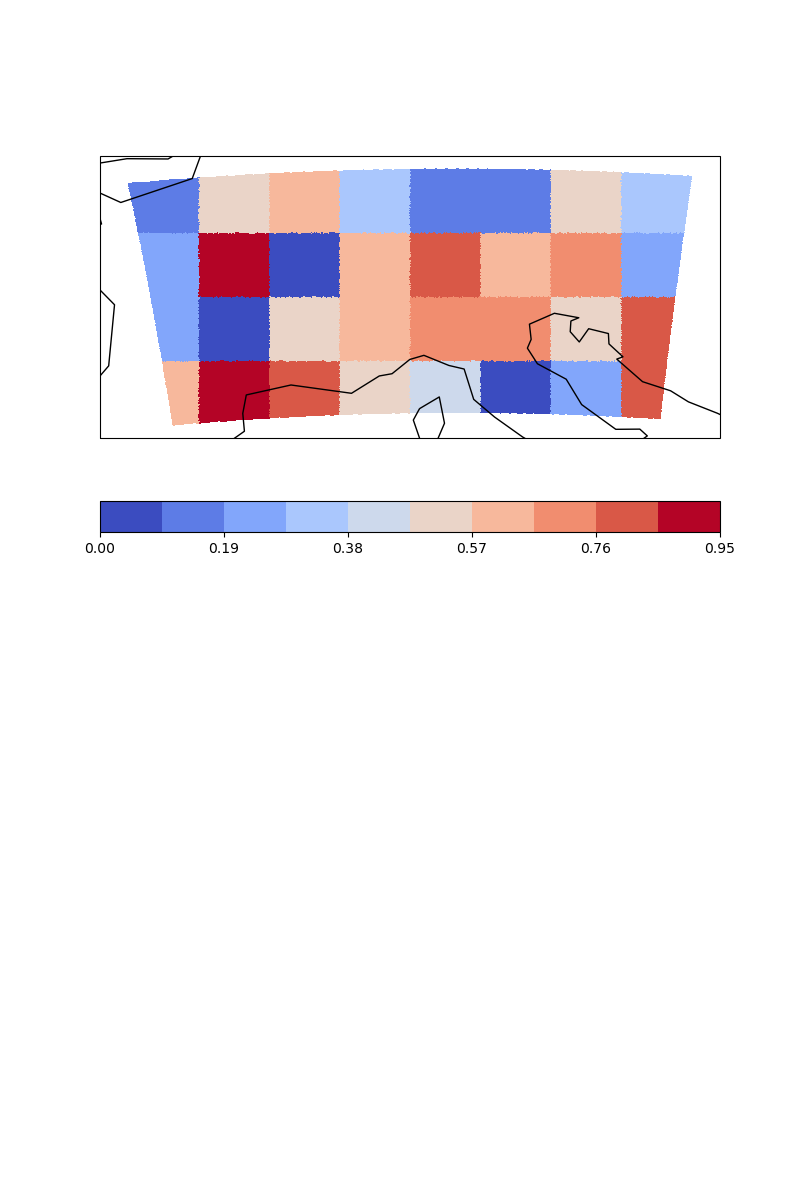

In [23]:
proj=ds_cell_combi.psy.plot.mapplot(
     name='rand_cg', 
     xgrid=None, ygrid=None, 
     datagrid=dict(c='k', lw=0.1),
     ax=(2, 1),
     cmap='coolwarm', 
     #map_extent=[6.7, 7.0, 46.6, 46.75]
     )
proj.update(datagrid=None)
     